In [1]:
#!pip install plotly==5.3.1
#!pip install --upgrade scikit-learn
!pip install -U kaleido
import glob
import operator
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict , namedtuple
from copy import copy
from functools import partial , singledispatch
from itertools import chain,combinations,product
from pathlib import Path
from time import strftime

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio

import scipy.stats as stats
import shap
from colorama import Fore,Style
from IPython.display import HTML, Image,display_html

from lightgbm import LGBMRegressor
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn import clone
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    MetaEstimatorMixin,
    OneToOneFeatureMixin,
    TransformerMixin,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    GradientBoostingRegressor,
    IsolationForest,
    RandomForestRegressor,
)
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.metrics import (
    confusion_matrix,
    median_absolute_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.pipeline import FunctionTransformer, make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils.validation import check_array, check_is_fitted
from xgboost import XGBClassifier


import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import optuna
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.preprocessing import scale
import yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import plotly
plotly.__version__

'5.22.0'

In [3]:
print(px.colors.sequential.Plasma)

['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b', '#ed7953', '#fb9f3a', '#fdca26', '#f0f921']


In [4]:
#!pip install git+https://github.com/plotly/Kaleido.git
    

In [5]:
# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#8c564b"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#17becf"
COLOR_SCHEME = np.array(("#8c564b", "#FFFCFA", "#17becf"))
TICKSIZE = 11

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        width=840,
        height=540,
        legend=dict(yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `None`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    if data_dir is None:
        data_dir = Path("data/")
    else:
        data_dir = Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)]


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)
    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()
    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include="object").columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].unique())
        frame2_unique = set(frame2[feature].unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = Path("images")
    if not isinstance(img_dir, Path):
        raise TypeError("The `img_dir` argument must be `Path` instance!")

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


def unit_norm(x):
    return x / np.sum(x)


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Preparation &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [6]:
train0= pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
TEST0= pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")
cols=TEST0.columns.tolist()
columns=cols
get_pretty_frame(train0.head(2))

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


In [7]:
train0.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Columns: 13 entries, id to price
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In train data,There are total 13 columns, 4 numeric and 9 object type.

In [8]:
TEST0.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Columns: 12 entries, id to clean_title
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

In [9]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df_train, df_test):
    combined_df = pd.concat([df_train, df_test])
    for c in combined_df.columns:
        if combined_df[c].dtype == 'object':
            combined_df[c] = combined_df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(combined_df[c].values))
            combined_df[c] = lbl.transform(combined_df[c].values)
    return combined_df.iloc[:len(df_train)], combined_df.iloc[len(df_train):]

In [10]:
train1,TEST1=labelencoder(train0,TEST0)

In [11]:
target='price'
trainX=train1.drop(target,axis=1)
trainY=train1[target]
TESTX=TEST1.drop(target,axis=1)
#TEST1Y=TEST1[target]

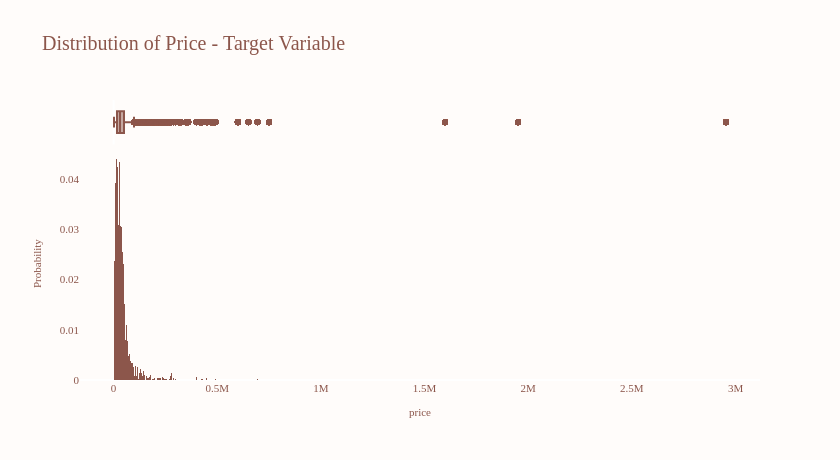

In [12]:
fig = px.histogram(
    train0,
    x="price",
    histnorm="probability",
    marginal="box",
    height=460,
    title="Distribution of Price - Target Variable"
       )
fig.update_yaxes(title="Probability", row=1)
save_and_show_fig(fig, "Price_distribution")

In [13]:
print(CLR + "Training Dataset:")
train_summary = frame_summary(trainX.drop('id',axis=1))
get_pretty_frame(train_summary, gradient=True)

Training Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
brand,int64,0,0.000,57,0.000,14,23088,0.122
model,int64,0,0.000,1897,0.010,670,2945,0.016
model_year,int64,0,0.000,34,0.000,2021,18198,0.097
milage,int64,0,0.000,6651,0.035,60000,1319,0.007
fuel_type,int64,0,0.000,8,0.000,2,165940,0.880
engine,int64,0,0.000,1117,0.006,719,3462,0.018
transmission,int64,0,0.000,52,0.000,38,49904,0.265
ext_col,int64,0,0.000,319,0.002,29,48658,0.258
int_col,int64,0,0.000,156,0.001,14,107674,0.571
accident,int64,0,0.000,3,0.000,2,144514,0.767


In [14]:
print(CLR + "Test Dataset:")
test_summary = frame_summary(TESTX.drop('id',axis=1))
get_pretty_frame(test_summary, gradient=True)

Test Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
brand,int64,0,0.000,55,0.000,14,15265,0.121
model,int64,0,0.000,1891,0.015,670,1923,0.015
model_year,int64,0,0.000,36,0.000,2021,12036,0.096
milage,int64,0,0.000,5700,0.045,170000,919,0.007
fuel_type,int64,0,0.000,8,0.000,2,110533,0.879
engine,int64,0,0.000,1117,0.009,719,2189,0.017
transmission,int64,0,0.000,52,0.000,38,33132,0.264
ext_col,int64,0,0.000,317,0.003,29,32370,0.258
int_col,int64,0,0.000,156,0.001,14,71613,0.570
accident,int64,0,0.000,3,0.000,2,96263,0.766


In [15]:
train_df=trainX
test_df=TESTX

In [16]:
print(CLR + "Training Dataset:")
train_num_descr = numeric_descr(train_df.drop('id',axis=1))
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
brand,23.161,15.868,0.000,0.000,3.000,9.000,21.000,36.000,53.000,54.000,56.000
model,867.252,521.808,0.000,10.000,73.000,431.000,817.000,1320.000,1732.000,1859.000,1897.000
model_year,2015.830,5.661,1974.000,2000.000,2004.000,2013.000,2017.000,2020.000,2022.000,2023.000,2024.000
milage,65705.295,49798.158,100.000,1087.000,4200.000,24115.000,57785.000,95400.000,161800.000,201509.000,405000.000
fuel_type,2.049,0.620,0.000,0.000,2.000,2.000,2.000,2.000,3.000,4.000,7.000
engine,613.782,278.247,0.000,53.000,150.000,386.000,628.000,854.000,1031.000,1109.000,1117.000
transmission,29.669,13.007,0.000,1.000,2.000,20.000,32.000,38.000,49.000,49.000,51.000
ext_col,157.330,114.585,0.000,22.000,29.000,29.000,128.000,281.000,304.000,308.000,318.000
int_col,34.997,39.857,0.000,10.000,10.000,14.000,14.000,56.000,150.000,155.000,155.000
accident,1.546,0.830,0.000,0.000,0.000,2.000,2.000,2.000,2.000,2.000,2.000


In [17]:
print(CLR + "Test Dataset:")
test_num_descr = numeric_descr(TEST0.drop('id',axis=1))
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
model_year,2015.798,5.674,1974.000,2000.000,2004.000,2013.000,2017.000,2020.000,2022.000,2023.000,2024.000
milage,66042.582,50223.858,100.000,1087.000,4126.000,24500.000,57500.000,95798.000,162000.000,206000.000,405000.000


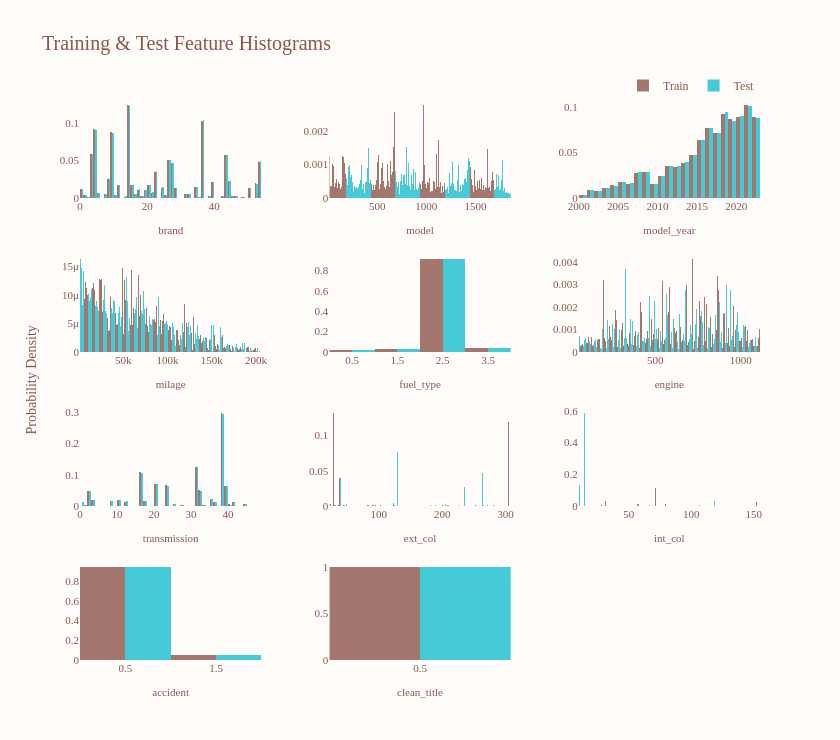

In [18]:
test_df1=test_df.drop('id',axis=1)
train_df1=train_df.drop('id',axis=1)
features = test_df1.columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip((train_df1, test_df1), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        start, end = np.percentile(frame[var], (1, 99))
        fig.add_histogram(
            x=frame[var],
            xbins=go.histogram.XBins(start=start, end=end),
            histnorm="probability density",
            marker_color=color,
            marker_line_width=0,
            opacity=0.8,
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"{var}", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature Histograms",
    bargap=0,
    bargroupgap=0,
)
save_and_show_fig(fig, "histograms")

In [19]:
# n_cols = 3
# n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

# fig = make_subplots(
#     rows=n_rows,
#     cols=n_cols,
#     y_title="Probability Density",
#     horizontal_spacing=0.1,
#     vertical_spacing=0.1,
# ).update_annotations(font_size=14)

# for frame, color, group in zip((train_df1, test_df1), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")):
#     for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
#         kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
#         fig.add_scatter(
#             x=kde["space"],
#             y=kde["vals"],
#             line=dict(dash="solid", color=color, width=1),
#             fill="tozeroy",
#             name=group,
#             legendgroup=group,
#             showlegend=k == 1,
#             row=row,
#             col=col,
#         )
#         fig.update_xaxes(title_text=f"{var}", row=row, col=col)

# fig.update_layout(
#     width=840,
#     height=740,
#     legend=dict(y=1, x=1),
#     title="Training & Test Feature KDEs"
#     ,
# )
# save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions confirm the previous statement, i.e. training and test subsets probably follow the same distribution, which is reflected as bins overlapping and similar density estimation. Let's continue analysis with correlation matrix and hierarchical clustering. 
</p>

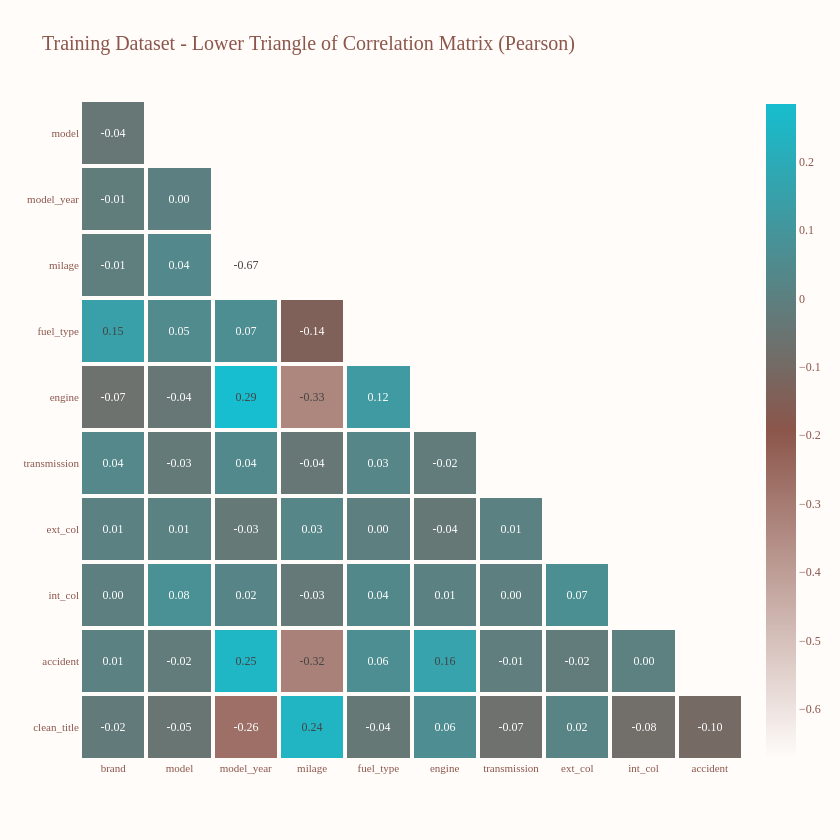

In [20]:
pearson_corr = train_df1.corr(method="pearson")
lower_triu_corr = get_lower_triangular_frame(pearson_corr)
colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[1, 0, 2]]))

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=colormap,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)",
    yaxis_autorange="reversed",
    width=840,
    height=840,
)
save_and_show_fig(fig, "pearson_corr_matrix")

In [21]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

       Feature 1    Feature 2  Absolute Pearson Correlation
0     model_year       milage                       0.66994
1         milage       engine                       0.33122
2         milage     accident                       0.31618
3     model_year       engine                       0.28534
4     model_year  clean_title                       0.26489
..           ...          ...                           ...
50         brand      int_col                       0.00477
51  transmission      int_col                       0.00253
52     fuel_type      ext_col                       0.00180
53         model   model_year                       0.00178
54       int_col     accident                       0.00065

[55 rows x 3 columns]


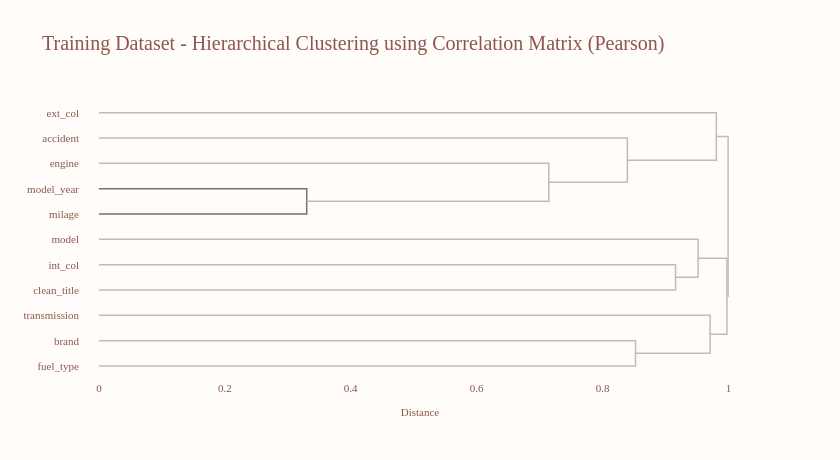

In [22]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>",
    height=460,
    width=840,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

In [23]:
# n_cols, n_features = 3, 6
# n_rows, axes = get_n_rows_and_axes(n_features, n_cols)

# fig = make_subplots(
#     rows=n_rows,
#     cols=n_cols,
#     horizontal_spacing=0.1,
#     vertical_spacing=0.15,
# )

# for (row, col), (feature1, feature2, corr) in zip(axes, abs_corr[:n_features].to_numpy()):
#     fig.add_scatter(
#         x=train_df1[feature1],
#         y=train_df1[feature2],
#         mode="markers",
#         name="",
#         row=row,
#         col=col,
#     )
#     fig.update_xaxes(title_text=feature1, row=row, col=col)
#     fig.update_yaxes(title_text=feature2, row=row, col=col)

# fig.update_layout(
#     title="Training Dataset - Highly Linear Correlated Pairs",
#     width=840,
#     height=540,
#     showlegend=False,
# )
# fig.update_traces(
#     marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
# )
# save_and_show_fig(fig, "highly_correlated_scatter_plots")

In [24]:
# n_cols = 3
# n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

# fig = make_subplots(
#     rows=n_rows,
#     cols=n_cols,
#     y_title="Price - Target Variable",
#     horizontal_spacing=0.07,
#     vertical_spacing=0.1,
# )
# fig.update_annotations(font_size=14, yshift=-45)

# for (row, col), feature in zip(axes, features):
#     fig.add_scatter(
#         x=train_df1[feature],
#         y=train_df1.price,
#         mode="markers",
#         name=feature,
#         row=row,
#         col=col,
#     )
#     fig.update_xaxes(
#         title_text=f"<b>{feature}</b>",
#         row=row,
#         col=col,
#     )
#     if not col == 1:
#         fig.update_yaxes(showticklabels=False, row=row, col=col)

# fig.update_layout(
#     title="Training Dataset - Price vs Remaining Features",
#     width=840,
#     height=840,
#     showlegend=False,
# )
# fig.update_traces(
#     marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
# )
# save_and_show_fig(fig, "scatter_plots")

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

In [25]:
# n_cols = 3
# n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

# fig = make_subplots(
#     rows=n_rows,
#     cols=n_cols,
#     y_title="Observed Values",
#     x_title="Theoretical Quantiles",
#     horizontal_spacing=0.1,
#     vertical_spacing=0.1,
# )
# fig.update_annotations(font_size=14, yshift=-45)

# for (row, col), feature in zip(axes, features):
#     (osm, osr), (slope, intercept, R) = stats.probplot(train_df1[feature].dropna(), rvalue=True)
#     x_theory = np.array([osm[0], osm[-1]])
#     y_theory = intercept + slope * x_theory
#     R2 = f"R\u00b2 = {R * R:.2f}"
#     fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
#     fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
#     fig.add_annotation(
#         x=-1.25,
#         y=osr[-1] * 0.95,
#         text=R2,
#         showarrow=False,
#         row=row,
#         col=col,
#         font_size=11,
#     )
#     fig.update_xaxes(
#         title_text=f"{feature}",
#         row=row,
#         col=col,
#     )

# fig.update_layout(
#     title="Training Dataset - Probability Plots against Normal Distribution",
#     width=840,
#     height=840,
#     showlegend=False,
# )
# fig.update_traces(
#     marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
#     line_color=COLOR_SCHEME[0],
# )
# save_and_show_fig(fig, "probability_plots")

Probability Plots against Normal Distribution

* Some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers. We will check three of mentioned: log-level, square-root and Yeo-Johnson. For this case, we will utilise the <code>probplot</code> function from the <code>scipy</code> module to get R-squared coefficients as earlier.

In [26]:
r2_scores = pd.DataFrame(index=("Original", "YeoJohnson", "Log", "Sqrt"))

for feature in features:
    orig = train_df1[feature].dropna()
    _, (*_, R_orig) = stats.probplot(orig, rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(orig)[0], rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log1p(orig), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(orig), rvalue=True)

    r2_scores[feature] = (
        R_orig * R_orig,
        R_yeojohn * R_yeojohn,
        R_log * R_log,
        R_sqrt * R_sqrt,
    )

r2_scores = r2_scores.transpose()
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
get_pretty_frame(r2_scores)

,Original,YeoJohnson,Log,Sqrt,Winner
brand,0.926,0.952,0.920,0.956,Sqrt
model,0.960,0.968,0.825,0.960,YeoJohnson
model_year,0.911,0.931,0.910,0.911,YeoJohnson
milage,0.933,0.989,0.900,0.990,Sqrt
fuel_type,0.431,0.449,0.426,0.403,YeoJohnson
engine,0.970,0.970,0.833,0.946,Original
transmission,0.918,0.926,0.726,0.849,YeoJohnson
ext_col,0.818,0.827,0.810,0.828,Sqrt
int_col,0.627,0.738,0.717,0.678,YeoJohnson
accident,0.527,0.528,0.525,0.523,YeoJohnson


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Features Importance</span></b><a class="anchor" id="features_importance"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, we will tackle the general problem of features' importance. Generally, sometimes not all variables are crucial during the training process, and only some are relevant for specific models. There are many methods, from selecting some top features based on the ANOVA test, mutual information, up to recursive feature selection with cross-validation. We can also select features from given models like random forest using the importance ratio. Generally, different methods may give different results. Moreover, it's good to include random variables in training data and measure their importance. <b>If some random numbers are more important than given features, it means that those variables are useless (may introduce a noise) from the problem perspective (but still can be useful in other tasks).</b> In this section, we will investigate decision process in a simple decision tree, and the we will focus on gradient boosting trees. We will see permutation tests, random variables, mutual information, one-way partial dependence plots (PDPs) and two-way PDPs.<br><br>
    
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Decision Process in Simple Decision Tree</span></b><a class="anchor" id="simple_decision_tree_and_its_decision_process"></a> [↑](#top)

In [27]:
trainY.head()

0     4200.0
1     4999.0
2    13900.0
3    45000.0
4    97500.0
Name: price, dtype: float64

In [28]:
# X = train_df1.copy()
# y = trainY.copy()

# DefaultDecisionTreeRegressor = partial(
#     DecisionTreeRegressor,
#     criterion="absolute_error",  # Watch out on learning time complexity.
#     random_state=42,
#     max_depth=3,
# )

# tree = DefaultDecisionTreeRegressor().fit(X, y)

In [29]:
# plt.figure(figsize=(11.5, 5.5), tight_layout=True)
# plot_tree(
#     decision_tree=tree,
#     feature_names=tree.feature_names_in_.tolist(),
#     filled=False,
#     rounded=True,
#     impurity=False,
#     proportion=True,
#     node_ids=True,
#     ax=plt.gca(),
#     fontsize=11,
# )
# plt.title("Decision Process in Decision Tree (depth = 3)")
# plt.savefig("images/decision_process_in_tree")
# plt.show()

In [30]:
# for depth in range(2, 7):
#     tree.set_params(max_depth=depth).fit(X, y)
#     considered_features = tree.tree_.feature[tree.tree_.feature != -2]  # type: ignore # -2 means a leaf
#     used_features = np.unique(considered_features)
#     used_features = X.columns[used_features].to_list()
#     print(CLR + f"Features at depth {depth}: {RED}{len(used_features):<5}", end="")
#     tree_cv_results = -cross_val_score(
#         estimator=tree,
#         X=X,
#         y=y,
#         cv=KFold(n_splits=5, shuffle=True, random_state=42),
#         scoring="neg_median_absolute_error",
#         n_jobs=2,
#     )
#     mean, std = tree_cv_results.mean(), tree_cv_results.std()
#     print(CLR + "MedAE:", RED + f"{mean:.2f} \u00b1 {std:.2f}")

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Modelling</span></b><a class="anchor" id="modelling"></a> [↑](#top)

In [31]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import optuna
from tqdm import tqdm
seed=42
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_3w25j1n
  JVM stdout: /tmp/tmp_3w25j1n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_3w25j1n/h2o_unknownUser_started_from_python.err


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_unknownUser_cy3lo0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [32]:
data_h2o=h2o.H2OFrame()

In [33]:
train_data_h2o=h2o.H2OFrame(train0)
test_data_h2o=h2o.H2OFrame(TEST0)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
#H2O models can encode categorical feqtures automatically.They must be explicitly
#converted to factor(categorical)data.
categorical_columns=[col for col in train_data_h2o if col.dtype=='object']
for col in categorical_columns:
    train_data_h2o[col]=train_data_h2o[col].asfactor()
    test_data_h2o[col]=test_data_h2o[col].asfactor()

In [35]:
#split train data into train and validation using H2O functions
splits=train_data_h2o.split_frame(ratios=[0.8],seed=seed)
train1=splits[0]
val=splits[1]

In [36]:
X=list(train1.drop('price',axis=1).columns)
y='price'
print(X)

['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [37]:
dnn_models=[]
def objective(trial):
    #params
    num_hidden_layers=trial.suggest_int('num_hidden_layers',1,10)
    hidden_layer_size=trial.suggest_int('hidden_layer_size',100,300,step=50)
    params={
        'hidden':[hidden_layer_size]*num_hidden_layers,
        'epochs': trial.suggest_int('epochs',5,100),
        'input_dropout_ratio':trial.suggest_float('input_dropout_ratio',0.1,0.3),
        'l1':trial.suggest_float('l1',1e-5,1e-1,log=True),
        'l2':trial.suggest_float('l2',1e-5,1e-1,log=True),
        'activation':trial.suggest_categorical('activation',["maxoutwithdropout", "tanhwithdropout", "tanh", "rectifierwithdropout", "rectifier", "maxout"])
    }
    
    if params['activation'] in ['RectifierWithDropout',"TanhWithDropout","MaxoutWithDropout"]:
        hidden_dropout_rtio=trial.suggest_float('hidden_dropout_ratio',0.1,1.0)
        params['hidden_dropout_ratios']=[hidden_dropout_rtio]*num_hidden_layers
    #Train model
    
    model=H2ODeepLearningEstimator(**params,
                                   standardize=True,
                                   categorical_encoding='auto',
                                   nfolds=5,
                                   keep_cross_validation_predictions=True,
                                   seed=seed
                                  )
    model.train(x=X,y=y,training_frame=train1)
    
    dnn_models.append(model)
    
    #CV score
    cv_metrics_df=model.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study= optuna.create_study(direction='minimize')
#study.optimize(objective,n_trials=20)

[I 2024-09-07 07:50:35,791] A new study created in memory with name: no-name-e64e2392-9f0c-4f75-b210-d7857754834f


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Training XGBoost and LightGBM base models</span></b><a class="anchor" id="modelling"></a> [↑](#top) 

In [ ]:
xgboost_lightgbm_models=[]
def objective(trial):
    
    params={
        'ntrees':trial.suggest_int('ntrees',50,5000),
        'max_depth':trial.suggest_int('max_depth',1,9),
        'min_rows':trial.suggest_int('min_rows',1,5),
        'sample_rate':trial.suggest_float('sample_rate',0.8,1.0),
        'col_sample_rate':trial.suggest_float('col_sample_rate',0.2,1.0),
        'col_sample_rate_per_tree':trial.suggest_float('col_sample_rate_per_tree',0.5,1.0)
    }
    
    grow_policy=trial.suggest_categorical('grow_policy',['depthwise','lossguide'])
    
    #add lightgbm specific params
    if grow_policy=='lossguide':
        tree_method='hist'
        params['max_bins']=trial.suggest_int('max_bind',20,256)
        params['max_leaves']=trial.suggest_int('max_leaves',31,1024)
    
    #add xgboost specific params
    else:
        tree_method='auto'
        params['booster']=trial.suggest_categorical('booster',['gbtree','gblinear','dart'])
        params['reg_alpha']=trial.suggest_float('reg_alpha',0.001,1)
        params['reg_lambda']=trial.suggest_float('reg_lambda',0.001,1)
        params['min_split_improvement']=trial.suggest_float('min_split_improvement',1e-10,1e-3,log=True)
    
    params['grow_policy']=grow_policy
    params['tree_method']=tree_method
    
    #train model
    model=H2OXGBoostEstimator(**params,
                              learn_rate=0.1,
                              categorical_encoding='auto',
                              nfolds=5,
                              keep_cross_validation_predictions=True,
                              seed=seed
                             )
    model.train(x=X,y=y,training_frame=train1)
    
    #store models
    xgboost_lightgbm_models.append(model)
    
    #CV
    
    cv_metrics_df=model.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)

[I 2024-09-07 07:50:35,819] A new study created in memory with name: no-name-c7660aac-6ef6-4029-a806-8e910d19a40e


xgboost Model Build progress: |█████████

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">5</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Training the meta model on dnn and xgb models</span></b><a class="anchor" id="modelling"></a> [↑](#top)


Most academic papers on stacked ensembles recommend choosing a simple linear-based algorithm for the meta-model. This is to avoid the meta-model overfitting to the predictions from the base models.

In [ ]:
base_models= xgboost_lightgbm_models # + dnn_models

In [ ]:
def objective(trial):
    #meta model params
    meta_model_params={
        'alpha':trial.suggest_float('alpha',0,1),
        'family':trial.suggest_categorical('family',['gaussian','tweedie']),
        'standardize':trial.suggest_categorical('standardize',['True','False']),
        'non_negative':True
        }
    
    ensemble=H2OStackedEnsembleEstimator(metalearner_algorithm='glm',
                                        metalearner_params=meta_model_params,
                                        metalearner_nfolds=5,
                                        base_models=base_models,
                                        seed=seed
                                        )
    ensemble.train(x=X,y=y,frame=train1)
    
    #CV
    
    cv_metrics_df=ensemble.cross_validation_metrics_summary().as_data_frame()
    cv_rmse_index=cv_metrics_df[cv_metrics_df['']=='rmse'].index
    cv_rmse=cv_metrics_df['mean'].iloc[cv_rmse_index]
    return cv_rmse

study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">6</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Finally build best model from optimal parameters</span></b><a class="anchor" id="modelling"></a> [↑](#top)

In [ ]:
best_meta_model_params=study.best_params
best_ensemble=H2OStackedEnsembleEstimator(metalearner_algorithm='glm',
                                         metalearner_params=best_meta_model_params,
                                         base_models=base_models,
                                         seed=seed)
best_ensemble.train(x=X,y=y,training_frame=train1)

In [ ]:
#check the best model
best_ensemble.summary()

In [ ]:
#check validation score of best model
ensemble_val_rmse=best_ensemble.model_performance(val).rmse()


In [ ]:
base_val_rmse=[]
for i in range(len(base_models)):
    base_val_rmse=base_model[i].model_performance(val).rmse()
models=['H2ODeepLearningEstimator']*len(dnn_models)+['H2OXGBoostEstimator']*len(xgboost_lightgbm_models)

base_val_rmse_df=pd.DataFrame([models,base_val_rmse]).T
base_val_rmse_df.columns=['model','rmse']

base_val_rmse_df=base_val_rmse_df.sort_values(by='val_rmse',ascending=True).reset_index(drop=True)
base_val_rmse_df.head(15)

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">7</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Prediction</span></b><a class="anchor" id="modelling"></a> [↑](#top)

In [ ]:
pred=best_ensemble.predict(TEST0)

In [ ]:
submit=pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [ ]:
submit.head()

In [ ]:
submission = pd.DataFrame(
    {
        "id": test.index,
        "price": best_ensemble.predict(test).round(2),  # type:ignore
    }
).set_index("id")

submission.to_csv("submission.csv")
get_pretty_frame(submission.head(), precision=2)

In [ ]:
# def create_numeric_feature(input_df):
#     use_columns = columns 
#     return input_df[use_columns].copy()

In [ ]:
# from contextlib import contextmanager
# from time import time

# class Timer:
#     def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

#         if prefix: format_str = str(prefix) + sep + format_str
#         if suffix: format_str = format_str + sep + str(suffix)
#         self.format_str = format_str
#         self.logger = logger
#         self.start = None
#         self.end = None

#     @property
#     def duration(self):
#         if self.end is None:
#             return 0
#         return self.end - self.start

#     def __enter__(self):
#         self.start = time()

#     def __exit__(self, exc_type, exc_val, exc_tb):
#         self.end = time()
#         out_str = self.format_str.format(self.duration)
#         if self.logger:
#             self.logger.info(out_str)
#         else:
#             print(out_str)

In [ ]:
# from tqdm import tqdm

# def to_feature(input_df):

#     processors = [
#         create_numeric_feature,
#     ]
    
#     out_df = pd.DataFrame()
    
#     for func in tqdm(processors, total=len(processors)):
#         with Timer(prefix='create' + func.__name__ + ' '):
#             _df = func(input_df)

#         assert len(_df) == len(input_df), func.__name__
#         out_df = pd.concat([out_df, _df], axis=1)
        
#     return out_df

In [ ]:
# train_feat_df = to_feature(train_df)
# test_feat_df = to_feature(test_df)

# Model

In [ ]:
# def objective0(trial,data=trainX,target=trainY):
    
#     train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    
#     param =   {
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.001, 0.002),
#         'lambda_l2': trial.suggest_uniform('lambda_l2', 6, 12),
#         "bagging_freq":  trial.suggest_int('bagging_freq', 4, 6),
#         "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.56, 0.57),
#         "feature_fraction": trial.suggest_uniform('feature_fraction', 0.75, 0.76),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.06, 0.08),
#         "verbosity":  trial.suggest_int('verbosity', 6, 8),  
#         'random_state': trial.suggest_int('random_state', 60, 68), 
#         'num_leaves': trial.suggest_int('num_leaves', 60, 70), 

#         #fixed part       
#         'objective': 'rmse', 
#         'reg_lambda': 1.,
#         'reg_alpha': .1,
#         'max_depth': 5, 
#         'n_estimators': 10000, 
#         'colsample_bytree': .5, 
#         'min_child_samples': 10,
#         'subsample_freq': 3,
#         'subsample': .9,
#         'importance_type': 'gain', 
#     }
    
#     model = lgb.LGBMRegressor(**param)      
#     model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
#     preds = model.predict(test_x)
#     rmse = mean_squared_error(test_y, preds,squared=False)
    
#     return rmse

# set n_trials

In [ ]:
# BestTrials=[]
# Studies=[]
# for i in range(1):
#     objective=[objective0][i]
    
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=100)
    
#     print('Number of finished trials:', len(study.trials))
#     print('Best trial:', study.best_trial.params)

#     Best_trial=study.best_trial.params
#     #print(Best_trial)

#     with open(f"Best_trial{i}.yaml", "w") as yaml_file:
#         yaml.dump(Best_trial, yaml_file)

#     fix_dict = {
#         'objective': 'rmse', 
#         'reg_lambda': 1.,
#         'reg_alpha': .1,
#         'max_depth': 5, 
#         'n_estimators': 10000, 
#         'colsample_bytree': .5, 
#         'min_child_samples': 10,
#         'subsample_freq': 3,
#         'subsample': .9,
#         'importance_type': 'gain', 
#       }

#     Best_trial.update(fix_dict)
#     BestTrials+=[Best_trial]
#     Studies+=[study]

# optuna.visualization.plot

In [ ]:
# for i,study in enumerate(Studies):
#     print()
#     print('================'*4)    
#     print(target)
#     display(optuna.visualization.plot_optimization_history(study))
#     display(optuna.visualization.plot_slice(study))
#     display(optuna.visualization.plot_param_importances(study))
#     print()

In [ ]:
# print(BestTrials[0])

In [ ]:
# train=trainX
# target=trainY
# test=TESTX

# Predict

In [ ]:
#submit=pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [ ]:
# preds = np.zeros(submit.shape[0])
# kf = KFold(n_splits=5,random_state=48,shuffle=True)
# for i in range(1):
#     for trn_idx, test_idx in kf.split(train[columns],target):
#         X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
#         y_tr,y_val=target.iloc[trn_idx],target.iloc[test_idx]
#         Best_trial=BestTrials[i] ###
#         model = lgb.LGBMRegressor(**Best_trial)
#         model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)])
#         preds+=model.predict(test[columns])/kf.n_splits 
#         rmse=mean_squared_error(y_val, model.predict(X_val),squared=False)
#         print(rmse)

In [ ]:
# submit.iloc[:,1]= preds
# display(submit)
# submit.to_csv('submission.csv',index=False)